## import python package

In [1]:
import collections
import numpy as np
import time
import torch
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display
import os
import zipfile, tarfile, hashlib, requests
from torch.utils import data as data

## code from d2l

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

def download(name, cache_dir=os.path.join('.', 'data')):
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def f(x):
    return 2 * torch.sin(x) + x**0.8

n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train)*5) # 排序后的训练样本
y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,)) # 训练样本的输出
x_test = torch.arange(0,5,0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数

def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列

    Defined in :numref:`sec_machine_translation`"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

def plot_kernel_reg(y_hat):
    plot(x_test,[y_truth,y_hat],'x','y',legend=['Truth','Pred'],xlim=[0,5],ylim=[-1,5])
    plt.plot(x_train,y_train,'o',alpha=0.5)

class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))

    def forward(self,queries,keys,values):
        # queries和attention_weights的形状为(查询个数，"键——值"对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        # 下面这条不是很讨喜，虽然可以达到目的，主要是因为在__init__函数之外，定义并赋值了某变量，放pycharm会有warning
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 /2,dim=1)
        # values的形状为（查询个数，"键——值"对个数）
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 这一部分的目的是，序列化输入x，y
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        # 初始化主类的数据存储
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # 逐一添加数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 依次画线，此处应当注意x，y的线的数量超过fmts的长度时，应当自定义self.fmts
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class Encoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class EncoderDecoder(torch.nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.rnn = torch.nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class AttentionDecoder(Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device, is_mask=True, is_reinforc=True):
    def xavier_init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == torch.nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    ## modify
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            ## modify
            if not is_mask:
                X_valid_len, Y_valid_len = torch.ones_like(X_valid_len, device=device)*X.shape[1], torch.ones_like(Y_valid_len, device=device)*Y.shape[1]
            ## modify be doubted.
            if is_reinforc:
                bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                            device=device).reshape(-1, 1)
                dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学,Really? I think there maybe some mistakes.
            else:
                dec_input = Y
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()	# 损失函数的标量进行“反向传播”
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def read_data_nmt():
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir,'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i,char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        # fix a little bug from original: if num_examples and i > num_examples:
        if num_examples and i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

def build_array_nmt(lines,vocab,num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l,num_steps,vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_data_nmt(batch_size,num_steps,num_examples=600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text,num_examples)
    src_vocab = Vocab(source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = Vocab(target,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array,src_valid_len = build_array_nmt(source,src_vocab,num_steps)
    tgt_array,tgt_valid_len = build_array_nmt(target,tgt_vocab,num_steps)
    data_arrays = (src_array,src_valid_len,tgt_array,tgt_valid_len)
    data_iter = load_array(data_arrays,batch_size)
    return data_iter,src_vocab,tgt_vocab

def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')



## homework code in ch10 sec1

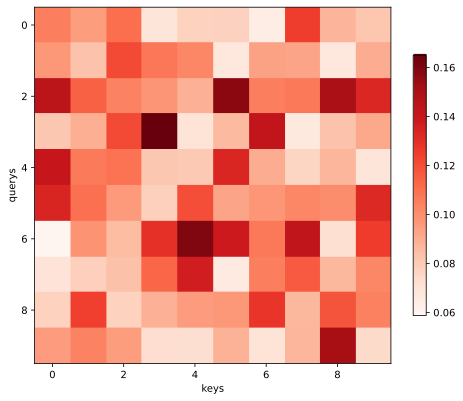

In [3]:
m = torch.rand(10, 10)
p_m = F.softmax(m, dim=0).reshape((1, 1, 10, 10))
show_heatmaps(p_m, xlabel='keys', ylabel='querys', figsize=(8, 8))

## homework code in ch10 sec2

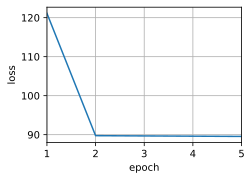

In [9]:
#T1
n_train = 200
x_train, _ = torch.sort(torch.rand(n_train)*5) 
y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,)) 
x_test = torch.arange(0,5,0.025) 
y_truth = f(x_test) 
n_test = len(x_test) 

X_tile = x_train.repeat((n_train,1))
Y_tile = y_train.repeat((n_train,1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=0.5)
animator = Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch{epoch + 1}, loss{float(l.sum()):.6f}')
    animator.add(epoch + 1,float(l.sum()))

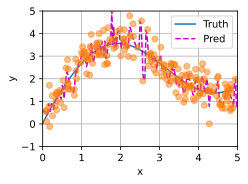

In [11]:
net.eval()
with torch.no_grad():
    plot_kernel_reg(net(x_test, keys, values))

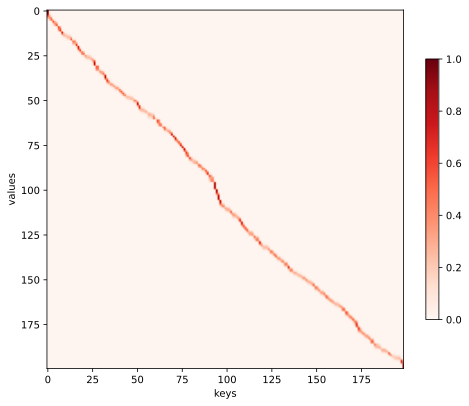

In [14]:
with torch.no_grad():
    show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), xlabel='keys', ylabel='values', figsize=(8,8))

In [15]:
#T4 change the square to the abosulte value.
class NewKernelRegression(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.w = nn.parameter.Parameter(torch.rand((1,)), requires_grad=True)
        self.attention_weight = None

    def forward(self, query, key, value):
        query = query.repeat_interleave(key.shape[1]).reshape((-1, key.shape[1]))
        self.attention_weight = F.softmax(torch.abs(query-key)*self.w, dim=1)
        return torch.bmm(self.attention_weight.unsqueeze(1), value.unsqueeze(-1)).reshape(-1)

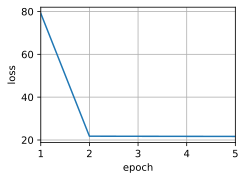

In [20]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train)*5) 
y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,)) 
x_test = torch.arange(0,5,0.1) 
y_truth = f(x_test) 
n_test = len(x_test) 

X_tile = x_train.repeat((n_train,1))
Y_tile = y_train.repeat((n_train,1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

net = NewKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=0.5)
animator = Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch{epoch + 1}, loss{float(l.sum()):.6f}')
    animator.add(epoch + 1,float(l.sum()))

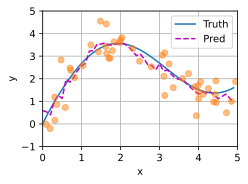

In [21]:
net.eval()
with torch.no_grad():
    plot_kernel_reg(net(x_test, keys, values))

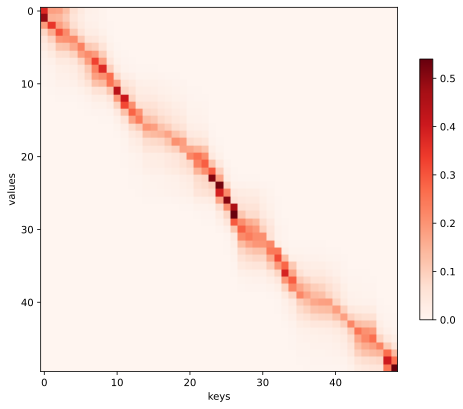

In [22]:
with torch.no_grad():
    show_heatmaps(net.attention_weight.unsqueeze(0).unsqueeze(0), xlabel='keys', ylabel='values', figsize=(8,8))

## homework code for ch10-sec3

In [13]:
#T1
queries = torch.rand((2, 20, 5))
keys = torch.rand((2, 10, 5))
values = torch.arange(40, dtype=torch.float).reshape(1, 10, 4).repeat(2, 1, 1)

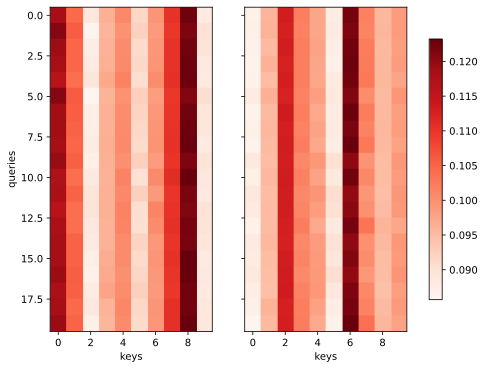

In [20]:
additive = AdditiveAttention(5, 5, 20, 0.5)
additive(queries, keys, values, None)
with torch.no_grad():
    additive_weight = additive.attention_weights
    show_heatmaps(additive_weight.unsqueeze(0), xlabel='keys', ylabel='queries', figsize=(8, 8))

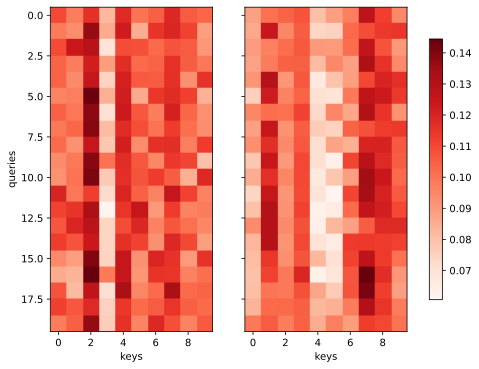

In [21]:
dot = DotProductAttention(0.5)
dot(queries, keys, values, None)
with torch.no_grad():
    dot_weight = dot.attention_weights
    show_heatmaps(dot_weight.unsqueeze(0), xlabel='keys', ylabel='queries', figsize=(8, 8))

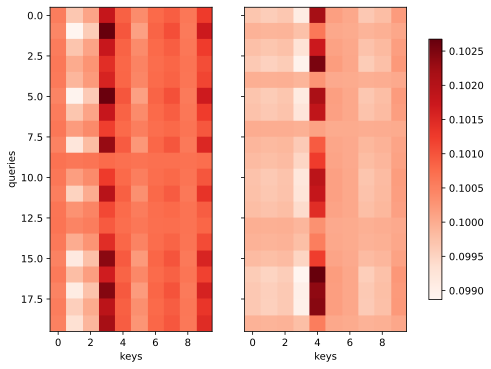

In [26]:
#T2
class DifferentLengthAttention(torch.nn.Module):
    def __init__(self, query_size, key_size, dropout, **kwargs) -> None:
        super().__init__()
        self.W = torch.nn.parameter.Parameter(torch.normal(0, 0.05, (query_size, key_size)), requires_grad=True)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, valid_lens: torch.Tensor):
        d = math.sqrt(self.W.size()[0]*self.W.size()[1])
        score = torch.bmm(torch.matmul(query, self.W), key.transpose(1, 2))/math.sqrt(d)
        self.attention_weights = masked_softmax(score, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), value)

# check its compability with different length queries and keys
dot_v2 = DifferentLengthAttention(1, 4, 0.5)
dot_v2(queries[:, :, :1], keys[:, :, :4], values, None)
with torch.no_grad():
    dot_weight_v2 = dot_v2.attention_weights
    show_heatmaps(dot_weight_v2.unsqueeze(0), xlabel='keys', ylabel='queries', figsize=(8, 8))

## homework code for sec4


In [35]:
#T1 T2
RNNType = {'rnn': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}
AttentionType = {'additive': AdditiveAttention, 'dot': DotProductAttention}

class FlexibleRNNEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hidden, num_layer, dropout, rnn_type: str, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = RNNType[rnn_type](embed_size, num_hidden, num_layer, dropout=dropout)
    
    def forward(self, x, *args):
        x = self.embedding(x).permute(1,0,2)
        output, state = self.rnn(x)
        return output, state


class FlexibleRNNFlexibleAttentionDecoder(nn.Module):
    '''
    for some special reason, when rnn_type is 'lstm', score_type cannot be 'dot'.
    '''
    def __init__(self, vocab_size, embed_size, num_hidden, num_layer, dropout, rnn_type: str, score_type: str, **kwargs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        _factor = 2 if rnn_type=='lstm' else 1
        self.rnn = RNNType[rnn_type](embed_size + num_hidden, num_hidden, num_layer, dropout=dropout)
        self.dense = nn.Linear(num_hidden, vocab_size)
        if score_type == 'additive':
            param = {'key_size': num_hidden, 'query_size': num_hidden*_factor, 'num_hiddens': num_hidden, 'dropout': dropout}
        elif score_type == 'dot':
            param = {'dropout': dropout}
        else:
            param = kwargs
        self.attention = AttentionType[score_type](**param)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        if isinstance(hidden_state, torch.Tensor):
            hidden = (hidden_state,)
        else:
            hidden = hidden_state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(torch.cat([h[-1] for h in hidden], dim=-1), dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

In [30]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, try_gpu()
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)


loss 0.020, 7185.8 tokens/sec on cuda:0


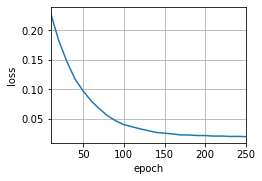

In [36]:
#T1
encoder = FlexibleRNNEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout, rnn_type='lstm')
decoder = FlexibleRNNFlexibleAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout, rnn_type='lstm', score_type='additive')
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

loss 0.019, 8049.9 tokens/sec on cuda:0


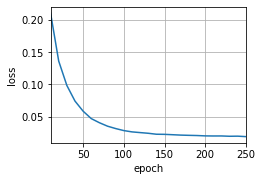

In [37]:
#T2
encoder = FlexibleRNNEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout, rnn_type='gru')
decoder = FlexibleRNNFlexibleAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout, rnn_type='gru', score_type='dot')
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [38]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


loss 0.020, 7226.6 tokens/sec on cuda:0


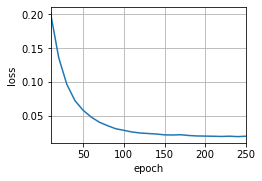

In [39]:
encoder = FlexibleRNNEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout, rnn_type='gru')
decoder = FlexibleRNNFlexibleAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout, rnn_type='gru', score_type='additive')
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [40]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


## homework code for sec5

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        output = self.attention(queries, keys, values, valid_lens)

        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


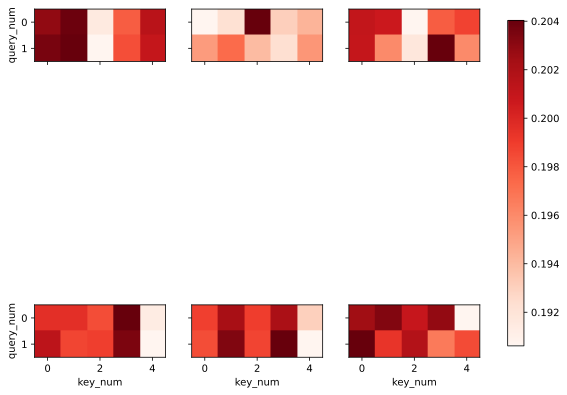

In [6]:
#T1
q,k,v = torch.rand((2, 2, 4)), torch.rand((2, 5, 3)), torch.rand((2, 5, 6))
ma = MultiHeadAttention(3, 4, 6, 15, 3, 0.2)
with torch.no_grad():
    _ = ma(q, k, v, None)
    show_heatmaps(ma.attention.attention_weights.reshape(2, 3, 2, 5), xlabel='key_num', ylabel='query_num', figsize=(10, 10))

## homework code for sec6

In [ ]:
#T2 在forward 函数中，引入可学习因子w，表示某种位置编码的权重关系？

 class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        self.w = nn.parameter.Parameter(torch.normal(1, 0.1, (1,)), requires_grad=True)
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.w * self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)
